In [1]:
import pandas as pd
import numpy as np
import yfinance as yahoo
import datetime as dt
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
tickers=['ADA-USD', 'BAT-USD', 'BTC-USD', 'DASH-USD', 'DCR-USD', 'DGB-USD', 'DOGE-USD', 'EOS-USD', 'ETH-USD',
         'LINK-USD', 'LTC-USD', 'MIOTA-USD', 'NANO-USD', 'NEO-USD', 'OMG-USD', 'XEM-USD', 'XLM-USD', 'XRP-USD', 'ZRX-USD']

cryptos = yahoo.download(tickers=tickers, period="1y",interval="60m")['Adj Close'].fillna(method='ffill')

cryptos.columns = [t.replace('-USD','') for t in tickers]

[*********************100%***********************]  19 of 19 completed


<AxesSubplot:xlabel='Datetime'>

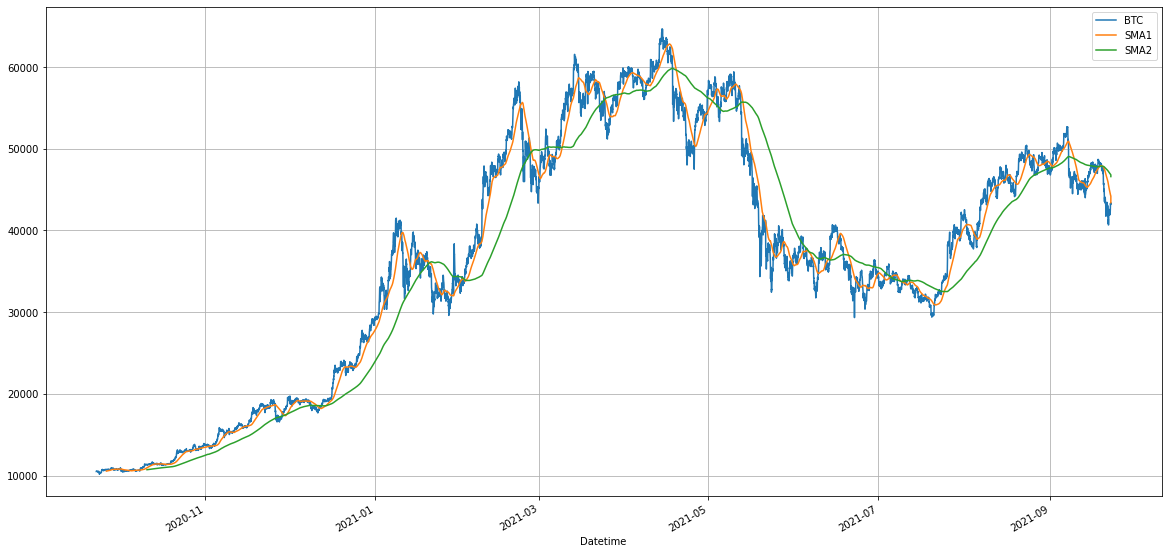

In [5]:
bitcoin = pd.DataFrame(cryptos['BTC'])
SMA1 = round(len(bitcoin)*0.01)
SMA2 = round(len(bitcoin)*0.05)
bitcoin['SMA1'] = bitcoin.BTC.rolling(SMA1).mean()
bitcoin['SMA2'] = bitcoin.BTC.rolling(SMA2).mean()
bitcoin.plot(figsize=(20,10),grid=True)

In [6]:
bitcoin['position'] = np.where(bitcoin['SMA1'] > bitcoin['SMA2'], 1, -1)

In [7]:
bitcoin.tail(20)

,BTC,SMA1,SMA2,position
Datetime,,,,
2021-09-22 17:00:00+01:00,43348.808594,44357.998935,46886.604818,-1
2021-09-22 18:00:00+01:00,43160.261719,44303.846413,46871.096390,-1
2021-09-22 19:00:00+01:00,43360.714844,44250.788042,46855.263226,-1
2021-09-22 19:51:06+01:00,43360.714844,44199.761808,46839.550023,-1
2021-09-22 19:51:09+01:00,43360.714844,44148.663042,46824.331808,-1
2021-09-22 19:51:11+01:00,43360.714844,44096.110396,46809.499741,-1
2021-09-22 19:51:20+01:00,43360.714844,44042.243342,46794.617651,-1
2021-09-22 19:51:25+01:00,43360.714844,43988.472301,46779.553706,-1
2021-09-22 19:51:30+01:00,43360.714844,43933.512296,46764.643943,-1


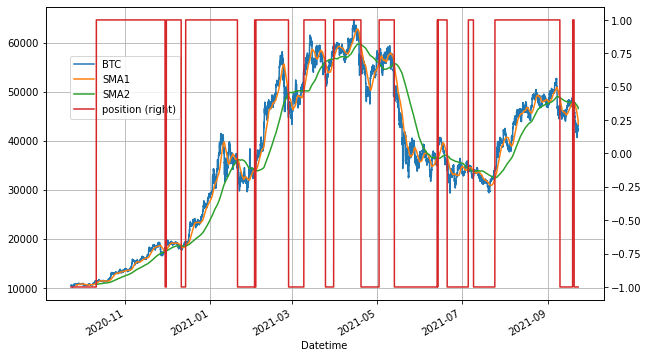

In [8]:
ax = bitcoin.plot(secondary_y='position', figsize=(10, 6), grid=True)
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

In [9]:
bitcoin['returns'] = (bitcoin['BTC'] - bitcoin['BTC'].shift(1)) / bitcoin['BTC'].shift(1)


In [10]:
bitcoin['strategy'] = bitcoin['position'].shift(1) * bitcoin['returns']

In [11]:
np.exp(bitcoin[['returns', 'strategy']].sum())  

returns     5.826762
strategy    3.569366
dtype: float64

In [12]:
# 5% of commissions per transaction is assumed
bitcoin['commissions'] = bitcoin['position'].shift(1) * (0.95 * bitcoin['returns'])

In [13]:
np.exp(bitcoin[['returns', 'strategy','commissions']].sum())  

returns        5.826762
strategy       3.569366
commissions    3.349358
dtype: float64

In [14]:
bitcoin[['returns', 'strategy']].std() * 252 ** 0.5  

returns     0.140569
strategy    0.140586
dtype: float64

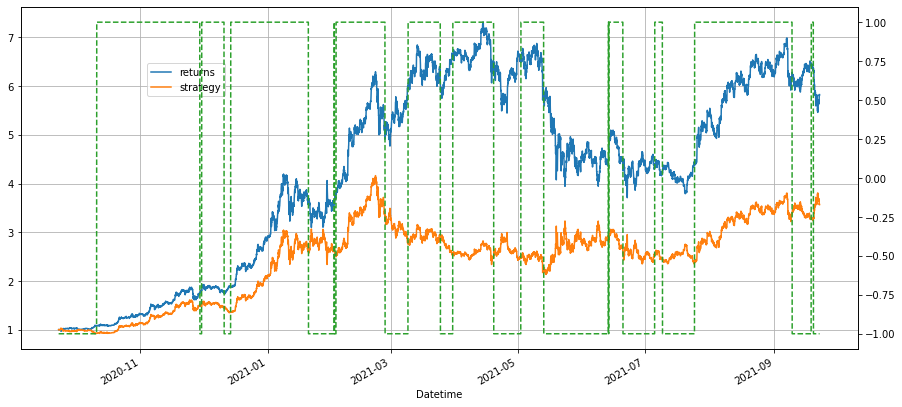

In [17]:
ax = bitcoin[['returns', 'strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(15, 7))
bitcoin['position'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
ax.grid(True)

In [18]:
from itertools import product

In [19]:
sma1 = range(1, 61, 4)
sma2 = range(100, 800, 10) 

In [20]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    bitcoin = pd.DataFrame(bitcoin['BTC'])
    bitcoin.dropna(inplace=True)
    bitcoin['returns'] = np.log(bitcoin['BTC'] / bitcoin['BTC'].shift(1))
    bitcoin['SMA1'] = bitcoin['BTC'].rolling(SMA1).mean()
    bitcoin['SMA2'] = bitcoin['BTC'].rolling(SMA2).mean()
    bitcoin.dropna(inplace=True)
    bitcoin['position'] = np.where(bitcoin['SMA1'] > bitcoin['SMA2'], 1, -1)
    bitcoin['strategy'] = bitcoin['position'].shift(1) * bitcoin['returns']
    bitcoin.dropna(inplace=True)
    perf = np.exp(bitcoin[['returns', 'strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['returns'],
                 'STRATEGY': perf['strategy'],
                 'OUT': perf['strategy'] - perf['returns']},
                 index=[0]), ignore_index=True)  

In [21]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      1050 non-null   int64  
 1   SMA2      1050 non-null   int64  
 2   MARKET    1050 non-null   float64
 3   STRATEGY  1050 non-null   float64
 4   OUT       1050 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 41.1 KB


In [22]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
9,1,190,2.371343,3.244020,0.872677
8,1,180,2.730875,3.431324,0.700449
22,1,320,0.718170,1.043537,0.325367
24,1,340,0.749714,1.074172,0.324459
21,1,310,0.756314,1.050360,0.294045
10,1,200,2.209196,2.359718,0.150523
0,1,100,4.031082,4.171492,0.140411


<AxesSubplot:xlabel='Datetime'>

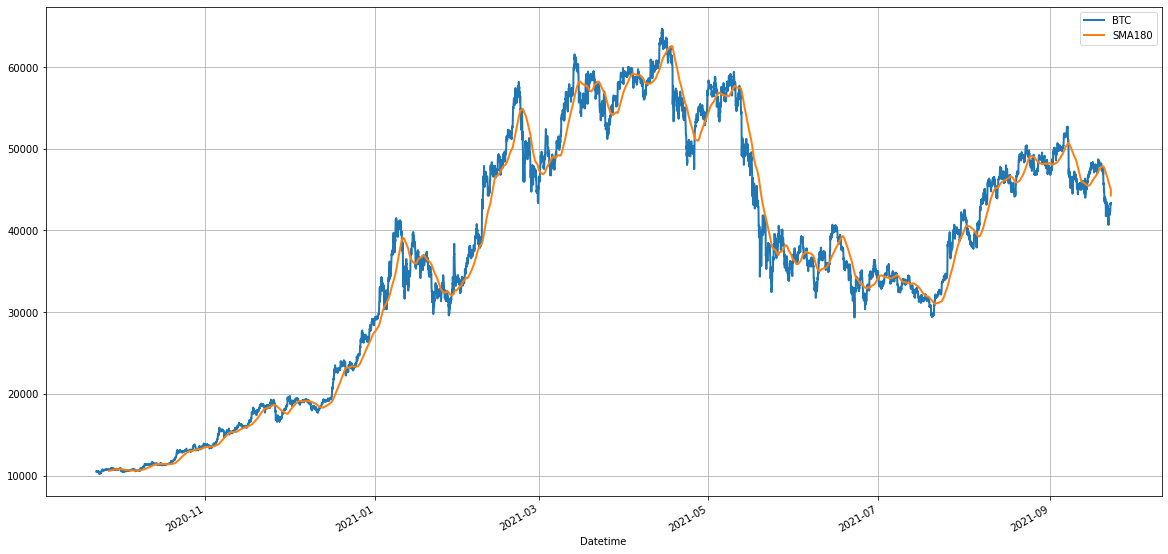

In [23]:
SMA180 = 110
bitcoin = pd.DataFrame(cryptos['BTC'])
bitcoin['SMA180'] = bitcoin.BTC.rolling(SMA180).mean()
bitcoin.plot(figsize=(20,10),grid=True,lw=2.)

In [24]:
bitcoin['position'] = np.where(bitcoin['BTC'] > bitcoin['SMA180'], 1, -1)

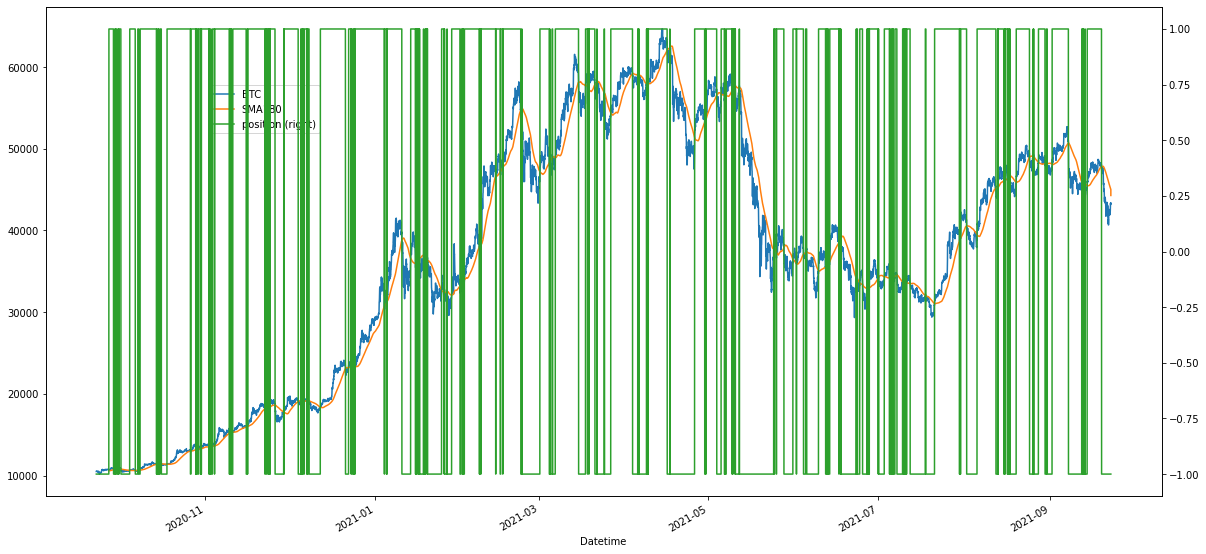

In [25]:
ax = bitcoin.plot(secondary_y='position', figsize=(20, 10))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

In [26]:
bitcoin['returns'] = (bitcoin['BTC'] - bitcoin['BTC'].shift(1)) / bitcoin['BTC'].shift(1)

In [27]:
bitcoin['strategy'] = bitcoin['position'].shift(1) * bitcoin['returns']

In [28]:
np.exp(bitcoin[['returns', 'strategy']].sum())  

returns     5.826762
strategy    3.485744
dtype: float64

In [29]:
bitcoin[['returns', 'strategy']].std() * 252 ** 0.5  

returns     0.140569
strategy    0.140587
dtype: float64

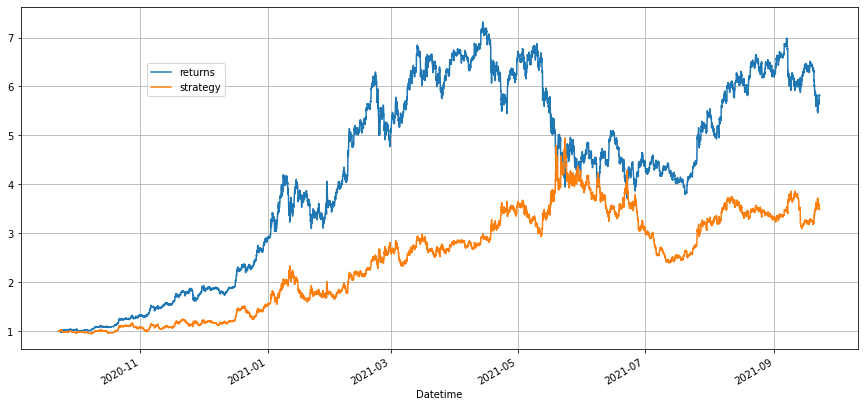

In [30]:
ax = bitcoin[['returns', 'strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(15, 7))
#bitcoin['position'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
ax.grid(True)

In [32]:
bitcoin.cumsum().fillna(value=0)

,BTC,SMA180,position,returns,strategy
Datetime,,,,,
2020-09-22 19:00:00+01:00,1.050001e+04,0.000000e+00,-1,0.000000,0.000000
2020-09-22 20:00:00+01:00,2.100008e+04,0.000000e+00,-2,0.000006,-0.000006
2020-09-22 21:00:00+01:00,3.152116e+04,0.000000e+00,-3,0.002007,-0.002007
2020-09-22 22:00:00+01:00,4.207310e+04,0.000000e+00,-4,0.004940,-0.004940
2020-09-22 23:00:00+01:00,5.259813e+04,0.000000e+00,-5,0.002390,-0.002390
...,...,...,...,...,...
2021-09-22 19:52:07+01:00,3.225745e+08,3.196405e+08,1644,1.762462,1.248682
2021-09-22 19:52:08+01:00,3.226179e+08,3.196849e+08,1643,1.762462,1.248682
2021-09-22 19:52:09+01:00,3.226612e+08,3.197293e+08,1642,1.762462,1.248682


In [33]:
bitcoin.returns.cumsum().fillna(value=0)

Datetime
2020-09-22 19:00:00+01:00    0.000000
2020-09-22 20:00:00+01:00    0.000006
2020-09-22 21:00:00+01:00    0.002007
2020-09-22 22:00:00+01:00    0.004940
2020-09-22 23:00:00+01:00    0.002390
                               ...   
2021-09-22 19:52:07+01:00    1.762462
2021-09-22 19:52:08+01:00    1.762462
2021-09-22 19:52:09+01:00    1.762462
2021-09-22 19:52:10+01:00    1.762462
2021-09-22 19:52:11+01:00    1.762462
Name: returns, Length: 8760, dtype: float64

In [34]:
cardano = pd.DataFrame(cryptos['ADA'])
SMA1 = 100
SMA2 = 500
cardano['SMA1'] = cardano.ADA.rolling(SMA1).mean()
cardano['SMA2'] = cardano.ADA.rolling(SMA2).mean()
cardano['position'] = np.where(cardano['SMA1'] > cardano['SMA2'], 1, -1)
cardano['returns'] = (cardano['ADA'] - cardano['ADA'].shift(1)) / cardano['ADA'].shift(1)
cardano['strategy'] = cardano['position'].shift(1) * cardano['returns']

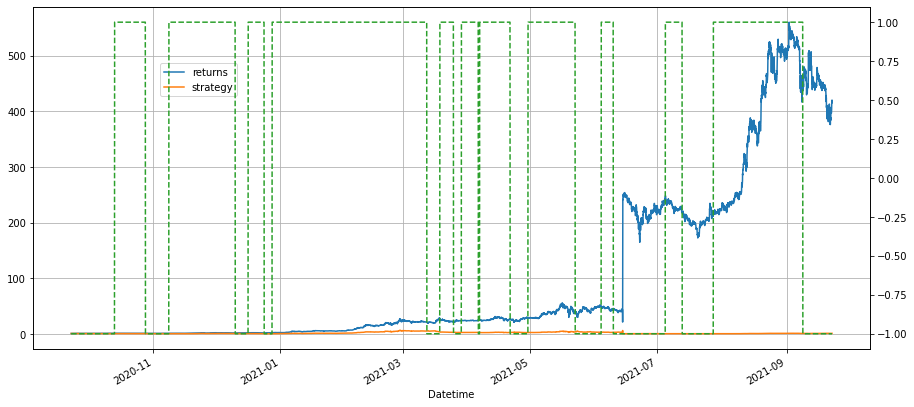

In [35]:
ax = cardano[['returns', 'strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(15, 7))
cardano['position'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
ax.grid(True)

In [42]:
cardano.strategy.cumsum().fillna(value=0)

Datetime
2020-09-22 19:00:00+01:00    0.000000
2020-09-22 20:00:00+01:00    0.004185
2020-09-22 21:00:00+01:00    0.004408
2020-09-22 22:00:00+01:00    0.004924
2020-09-22 23:00:00+01:00    0.008358
                               ...   
2021-09-22 19:52:07+01:00   -1.923952
2021-09-22 19:52:08+01:00   -1.923952
2021-09-22 19:52:09+01:00   -1.923952
2021-09-22 19:52:10+01:00   -1.923952
2021-09-22 19:52:11+01:00   -1.921525
Name: strategy, Length: 8760, dtype: float64

In [46]:
sma1 = range(1, 61, 4)
sma2 = range(100, 800, 10) 

In [47]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    cardano = pd.DataFrame(cardano['ADA'])
    cardano.dropna(inplace=True)
    cardano['returns'] = np.log(cardano['ADA'] / cardano['ADA'].shift(1))
    cardano['SMA1'] = cardano['ADA'].rolling(SMA1).mean()
    cardano['SMA2'] = cardano['ADA'].rolling(SMA2).mean()
    cardano.dropna(inplace=True)
    cardano['position'] = np.where(cardano['SMA1'] > cardano['SMA2'], 1, -1)
    cardano['strategy'] = cardano['position'].shift(1) * cardano['returns']
    cardano.dropna(inplace=True)
    perf = np.exp(cardano[['returns', 'strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['returns'],
                 'STRATEGY': perf['strategy'],
                 'OUT': perf['strategy'] - perf['returns']},
                 index=[0]), ignore_index=True) 

In [48]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      1050 non-null   int64  
 1   SMA2      1050 non-null   int64  
 2   MARKET    1050 non-null   float64
 3   STRATEGY  1050 non-null   float64
 4   OUT       1050 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 41.1 KB


In [49]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
0,1,100,1.0,1.0,0.0
689,37,690,1.0,1.0,0.0
691,37,710,1.0,1.0,0.0
692,37,720,1.0,1.0,0.0
693,37,730,1.0,1.0,0.0
694,37,740,1.0,1.0,0.0
695,37,750,1.0,1.0,0.0


In [50]:
cardano = pd.DataFrame(cryptos['ADA'])
SMA110 = 110
cardano['SMA110'] = cardano.ADA.rolling(SMA110).mean()
cardano['positions'] = np.where(cardano['ADA'] > cardano['SMA110'], 1, -1)
cardano['returns'] = (cardano['ADA'] - cardano['ADA'].shift(1)) / cardano['ADA'].shift(1)
cardano['strategy'] = cardano['positions'].shift(1) * cardano['returns']

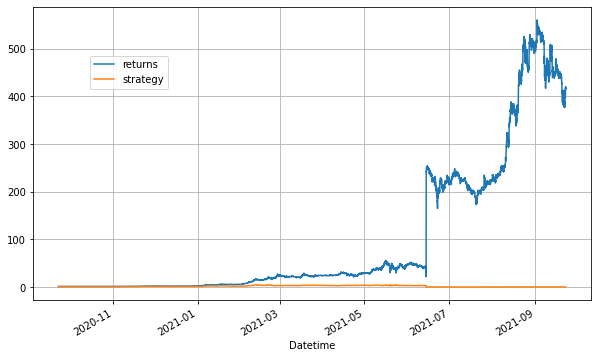

In [51]:
ax = cardano[['returns', 'strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6))
#cardano['positions'].plot(ax=ax, secondary_y='position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
ax.grid(True)

<AxesSubplot:xlabel='Datetime'>

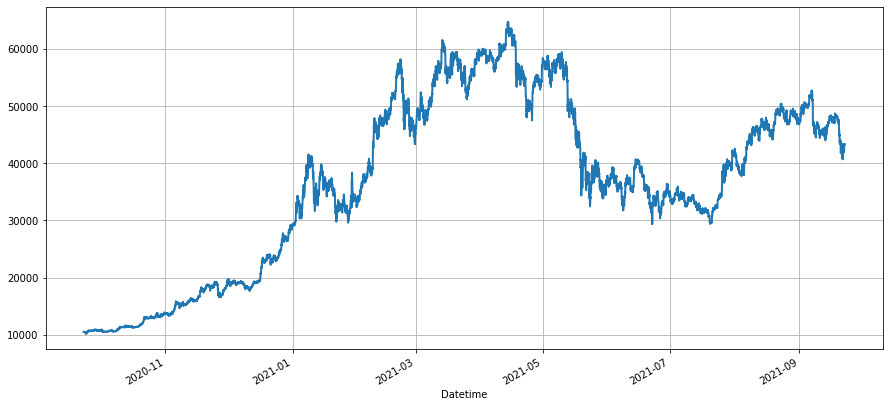

In [52]:
bitcoin.BTC.plot(figsize=(15,7),grid=True,lw=2.)

In [53]:
bitcoin.BTC.pct_change().cumsum()

Datetime
2020-09-22 19:00:00+01:00         NaN
2020-09-22 20:00:00+01:00    0.000006
2020-09-22 21:00:00+01:00    0.002007
2020-09-22 22:00:00+01:00    0.004940
2020-09-22 23:00:00+01:00    0.002390
                               ...   
2021-09-22 19:52:07+01:00    1.762462
2021-09-22 19:52:08+01:00    1.762462
2021-09-22 19:52:09+01:00    1.762462
2021-09-22 19:52:10+01:00    1.762462
2021-09-22 19:52:11+01:00    1.762462
Name: BTC, Length: 8760, dtype: float64

<AxesSubplot:xlabel='Datetime'>

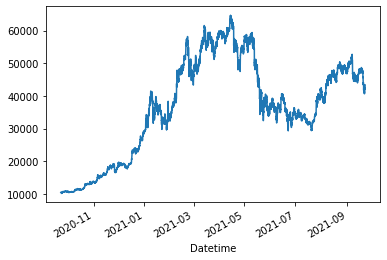

In [54]:
bitcoin['BTC'].plot()